In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
# import all stock prices 
df = pd.read_csv("TSLA.csv", index_col=0)
df1 = df['Open']
df = pd.read_csv("GOOGL.csv", index_col=0)
df2 = df['Open']
df = pd.read_csv("DJI.csv", index_col=0)
df3 = df['Open']
print(df1.shape)

(2227,)


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [4]:
minmax_scaler = MinMaxScaler()
df1 = minmax_scaler.fit_transform(df1.values.reshape(-1,1))
df2 = minmax_scaler.fit_transform(df2.values.reshape(-1,1))
df3 = minmax_scaler.fit_transform(df3.values.reshape(-1,1))

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
# function to create train, validation, test data given stock data and sequence length
def load_data(data_raw, seq_len): 
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    print(data.shape)
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    #x_train = np.squeeze(x_train)
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    #x_valid = np.squeeze(x_valid)
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    #x_test = np.squeeze(x_test)
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
valid_set_size_percentage = 10 
test_set_size_percentage = 10
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df1, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


(2207, 20, 1)
x_train.shape =  (1765, 19, 1)
y_train.shape =  (1765, 1)
x_valid.shape =  (221, 19, 1)
y_valid.shape =  (221, 1)
x_test.shape =  (221, 19, 1)
y_test.shape =  (221, 1)


# TesnorFlow Model

In [6]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 1 
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 30 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


## Training

In [7]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size / batch_size)):
        x_batch, y_batch = next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('epoch %d: MSE train: %.6f, MSE valid: %.6f' % (np.ceil(iteration*batch_size/train_set_size), mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

epoch 0: MSE train: 0.005869, MSE valid: 0.023251
epoch 1: MSE train: 0.000746, MSE valid: 0.003687
epoch 2: MSE train: 0.000378, MSE valid: 0.001457
epoch 3: MSE train: 0.000279, MSE valid: 0.000956
epoch 4: MSE train: 0.000296, MSE valid: 0.000791
epoch 5: MSE train: 0.000252, MSE valid: 0.000745
epoch 6: MSE train: 0.000275, MSE valid: 0.000774
epoch 7: MSE train: 0.000235, MSE valid: 0.000698
epoch 8: MSE train: 0.000227, MSE valid: 0.000677
epoch 9: MSE train: 0.000257, MSE valid: 0.000818
epoch 10: MSE train: 0.000246, MSE valid: 0.000697
epoch 11: MSE train: 0.000212, MSE valid: 0.000638
epoch 12: MSE train: 0.000218, MSE valid: 0.000681
epoch 13: MSE train: 0.000203, MSE valid: 0.000598
epoch 14: MSE train: 0.000198, MSE valid: 0.000584
epoch 15: MSE train: 0.000205, MSE valid: 0.000591
epoch 16: MSE train: 0.000205, MSE valid: 0.000629
epoch 17: MSE train: 0.000207, MSE valid: 0.000584
epoch 18: MSE train: 0.000195, MSE valid: 0.000554
epoch 19: MSE train: 0.000187, MSE valid:

# Testing

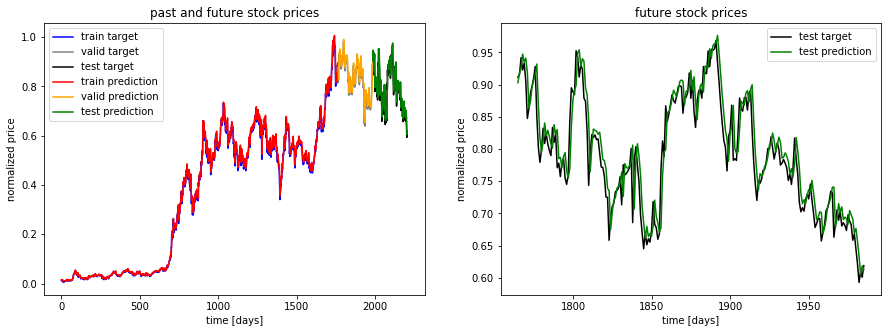

In [8]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');